## Matrix Multiplication

We start by importing numpy and numba. We also define a checksum function as a fast checking mechanism. **In this case, we use as checksum the sum of all elements divided by N^2, where N is the dimension of the matrix. Other types of checksum could be implemented.**

**We will assume that we have a square matrix (N x N).** 

In [2]:
# conda install numba cudatoolkit=10.1
import time
import numpy as np
from numpy.random import seed
from numpy.random import rand
from numba import jit,njit,prange,cuda, types, float32
import matplotlib.pyplot as plt

%matplotlib inline 

seed(1)
def randomize_array(size):
    lst = 10.*rand(size)+1.
    return lst

mat_size = 256
mat_size_sq = mat_size*mat_size
a = np.array(randomize_array(mat_size_sq), dtype=np.float32)
b = np.array(randomize_array(mat_size_sq), dtype=np.float32)

# Compile and run the check in parallel with Numba
# (we do this to keep this part fast, but it is not the main objective of the execise)
@njit(parallel = True)
def check(c, N):
    NN = N * N
    sum = 0.0
    for i in prange(NN):
        sum += c[i] / NN
    return sum

### Interpreted Matrix Multiplication

Next, we implement the standard matrix-multiplication algorithm. With the current matrix size N=256*256, it takes about 15s to complete.

In [3]:
def mat_mul_base(a,b,c,size):
    for i in range(size):
        for j in range(size):
            for k in range(size):
                c[i*size+j]+=a[i*size+k]*b[k*size+j]
                
c = np.zeros(mat_size_sq, dtype=np.float32)
start = time.time()
mat_mul_base(a, b, c, mat_size)
end = time.time()

print('Elapsed time: ',end-start)
print(check(c, mat_size))

Elapsed time:  14.29716181755066
9217.815409995615


### Compiled Matrix Multiplication

Python is an interpreted language, which means standard loops like these are very, very slow...

Fortunately, we can use numba to compile this kernel just-in-time. The performance will be comparable to C or FORTRAN code!
It should take less than a second with the same matrix size.

In [4]:
@njit
def mat_mul_numba(a,b,c,size):
    for i in range(size):
        for j in range(size):
            for k in range(size):
                c[i*size+j]+=a[i*size+k]*b[k*size+j]
                
c = np.zeros(mat_size_sq, dtype=np.float32)
start = time.time()
mat_mul_numba(a, b, c, mat_size)
end = time.time()

print('Elapsed time: ',end-start)
print(check(c, mat_size))

Elapsed time:  0.21044158935546875
9217.815409995615


We are going to optimize this code a lot. So from now on, we will use a much larger matrix size. Let's try again. This should take less than 30s. **[This one took me sometimes 30s and sometimes 42s. It probably depends on the assigned CPU Maybe change it to less than 1 min]**

In [5]:
mat_size = 2048
mat_size_sq = mat_size*mat_size
a = np.array(randomize_array(mat_size_sq), dtype=np.float32)
b = np.array(randomize_array(mat_size_sq), dtype=np.float32)

In [6]:
c = np.zeros(mat_size_sq, dtype=np.float32)
start = time.time()
mat_mul_numba(a, b, c, mat_size)
end = time.time()

print('Elapsed time: ',end-start)
print(check(c, mat_size))

Elapsed time:  30.521780967712402
73721.29736233875


### Cache efficiency

The standard implementation that we have above, with loops on i, j, k is actually not very cache-friendly. It accesses memory cells that are always very far apart in memory. A well-known trick is to switch the k and j loop so that most memory accesses become continous in memory for matrix c and b. This **greatly** improves cache-efficiency, and performance. See by yourself!

In [7]:
@njit
def mat_mul_numba_opt(a,b,c,size):
    for i in range(size):
        for k in range(size):  # We just switched j and k
            for j in range(size):
                c[i*size+j]+=a[i*size+k]*b[k*size+j]
                
c = np.zeros(mat_size_sq, dtype=np.float32)
start = time.time()
mat_mul_numba_opt(a, b, c, mat_size)
end = time.time()

print('Elapsed time: ',end-start)
print(check(c, mat_size))

Elapsed time:  16.670458555221558
73721.29736233875


### Parallelization on CPU

To have a fair comparison with the GPU code that we are going to see in the next section, we can parallelize the CPU code. With 8 CPU cores, the code sould run ~8 times faster.
This will be our baseline code to compare against the GPU code!

In [8]:
@njit(parallel = True)   # we add the option parallel=True to enable threading
def mat_mul_numba_parallel(a,b,c,size):
    for i in prange(size):  # we use prange instead of range. This is the loop being parallelized.
        for k in range(size):
            for j in range(size):
                c[i*size+j]+=a[i*size+k]*b[k*size+j]
                
c = np.zeros(mat_size_sq, dtype=np.float32)
start = time.time()
mat_mul_numba_parallel(a, b, c, mat_size)
end = time.time()

print('Elapsed time: ',end-start)
print(check(c, mat_size))

Elapsed time:  15.467092752456665
73721.29736233875


### GPU CUDA implementation

Below is the CUDA equivalent of the previous code.

**How many threads?**

We create a grid of 2048*2048 threads, in other words, we have one thread per matrix cell.

The GPU does not have enough CUDA cores to execute all of our 2048*2048 threads in parallel. But we don't care. The GPU will take care of this and schedule the work accordingly.

**What does a thread compute?**

Each thread will compute the inner k loop of the previous code. In other word, each thread will compute the dot product between column **i** of matrix **a** and row **j** of matrix **b**.

In fact, we don't need the loops on i and j anymore, because we have one thread per i,j corrdinate.
Note that inside the kernel, a thread knows what cell to compute by fetching its coordinates in the grid. This is the only way to differentiate two threads apart!

**What is the block size?**

We must specify the block size, a.k.a **the number of threads per block**. This must be a **multiple of 32**, and the optimal value will vary by code and by architecture. The upper limit is somwhere around 1024 and 4096, which amounts to 32\*32 to 64\*64 for two-dimensional blocks.

Here, we define a block of threads to be 16\*16 = 256 threads. Therefore, we will have 256 threads per block.
Feel free to try different threads per block (TPB) values below! This can greatly affect performance.

**What is the grid size?**

Now that we have defined the block size, we can compute the grid size. Remember, we want the grid size to be at least 2048\*2048 threads. However, the size of the grid must be given in number of blocks. Therefore, we can simply define:
- grid_size = mat_size / TPB = 2048 / 16 = 128 blocks in one dimension.

And the grid has grid_size\*grid_size = 128\*128 = 16384 blocks of threads in total.

Note that our grid indeed has exactly 16384 \* 256  = 2048 \* 2048 threads.

**How to launch the kernel?**

We launch the CUDA kernel by passing our number of blockspergrid and threadsperblock. The GPU will dispatch the blocks to its streaming multiprocessors where they will be executed in locksteps of 32 threads (warping).

**How fast is it?**

Let's try it out!

In [10]:
@cuda.jit
def mat_mul_numba_cuda(a,b,c,size):
    i=cuda.blockIdx.y*cuda.blockDim.y+cuda.threadIdx.y
    j=cuda.blockIdx.x*cuda.blockDim.x+cuda.threadIdx.x
    
    if i >= size or j >= size:
        return
    
    for k in range(size):
        c[i*size+j]+=a[i*size+k]*b[k*size+j]

TPB = 16
threadsperblock = (TPB,TPB)
grid_size = int(np.ceil(mat_size / TPB))
blockspergrid = (grid_size,grid_size)

c = np.zeros(mat_size_sq, dtype=np.float32)
start=time.time()
mat_mul_numba_cuda[blockspergrid, threadsperblock](a,b,c,mat_size)
end=time.time()

print('Elapsed time: ',end-start)
print(check(c, mat_size))

Elapsed time:  0.5692727565765381
73721.2973622568


### Performance

This should be pretty fast! Note that the time here includes the time needed to copy matrices a and b to the GPU, and then matrix c back to the cpu. Transferring data is often a major bottlneck on the GPU. The execution of the kernel itself is often much faster.

Because the complexity of the matrix-matrix multiplication is O(n^3), the number of computations grow much faster compared to the amount of memory required O(n).

**One can expect the GPU to perform better compared to the CPU with larger matrix sizes.**

Let's see if this is true!

64 0.8445911341262163
128 0.3222680630487676
256 10.12960235640648
512 26.759421081376296
1024 42.54226913385316
2048 41.44659082435901
4096 172.94205957829664


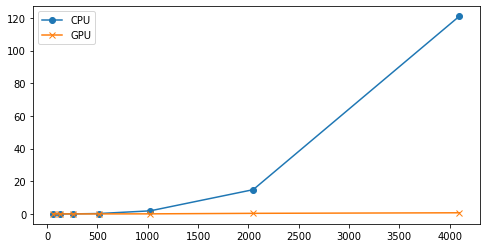

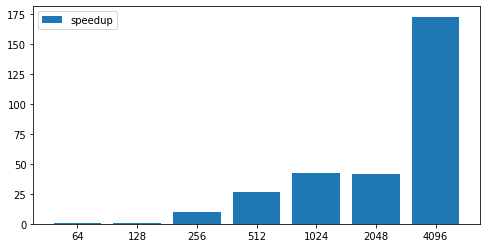

In [11]:
cpu_times = []
gpu_times = []
speedups = []

TPB = 16
threadsperblock = (TPB,TPB)
grid_size = int(np.ceil(mat_size / TPB))
blockspergrid = (grid_size,grid_size)

sizes = [64, 128, 256, 512, 1024, 2048, 4096]
for mat_size in sizes:
    mat_size_sq = mat_size*mat_size
    a = np.array(randomize_array(mat_size_sq), dtype=np.float32)
    b = np.array(randomize_array(mat_size_sq), dtype=np.float32)
    
    # CPU
    c = np.zeros(mat_size_sq, dtype=np.float32)
    start = time.time()
    mat_mul_numba_parallel(a, b, c, mat_size)
    end = time.time()
    ctime = end-start
    cpu_times.append(ctime)
    
    # GPU
    c = np.zeros(mat_size_sq, dtype=np.float32)
    start=time.time()
    mat_mul_numba_cuda[blockspergrid, threadsperblock](a,b,c,mat_size)
    end=time.time()
    gtime = end-start
    gpu_times.append(gtime)
    
    speedups.append(ctime/gtime)
    print('Matrix size:',mat_size, 'GPU speed-up:'.ctime/gtime)

plt.figure(figsize=(8,4))
plt.plot(sizes, cpu_times, marker='o', markevery=1, label='CPU')
plt.plot(sizes, gpu_times, marker='x', markevery=1, label='GPU')
plt.legend(loc='upper left')
plt.draw()

plt.figure(figsize=(8,4))
plt.bar(np.arange(0,len(speedups)), speedups, label='speedup')
plt.legend(loc='upper left')
plt.xticks(np.arange(0,len(speedups)), sizes)
plt.draw()

plt.show()

Elapsed time:  1.772583246231079
147448.4791684216


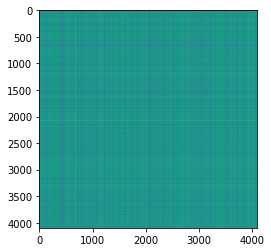

In [12]:
TPB = 16

@cuda.jit
def mat_mul_numba_cuda_tiles(a,b,c,size):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= size or y >= size:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    sum = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx][ty] = a[(ty + i * TPB) * size + x]
        sB[tx][ty] = b[y * size + tx + i * TPB]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            sum += sA[tx][j] * sB[j][ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    c[y * size + x] = sum
    
threadsperblock = (TPB,TPB)
blockspergrid_x = int(np.ceil(mat_size / threadsperblock[0]))
blockspergrid_y = int(np.ceil(mat_size / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

c=np.zeros(mat_size_sq, dtype=np.float32)

start=time.time()
mat_mul_numba_cuda_tiles[blockspergrid, threadsperblock](a,b,c,mat_size)
end=time.time()

c = c.reshape(mat_size*mat_size)
print('Elapsed time: ',end-start)
print(check(c, mat_size))

%matplotlib inline 
c = c.reshape(mat_size,mat_size)
plt.imshow(c)
plt.show()